In [219]:
import numpy as np
import pandas as pd
from qpsolvers import solve_qp
import matplotlib.pyplot as plt

In [139]:
data = pd.read_csv('./Datasets/OHSUMED/QueryLevelNorm/Fold1/train.txt', delimiter=" ", header=None)
data = pd.DataFrame(data)
data = data.drop([47, 48, 49],axis=1) # 47, 48, 49th cols are ["#docid", "=", docID]

In [140]:
# For deleting unnecessary prefix eg, "1:0.123432", "2:12.234" in each cell
def del_colname(x):
    x = str(x)
    x = x.split(":")
    return float(x[-1])
data = data.apply(np.vectorize(del_colname))

In [141]:
k = 7
q_min = int(data[1].min())
# q_max = int(data[1].max())
q_max = q_min+30
qnum = q_max - q_min + 1

w = pd.Series([0]*45)
slack = 0
SqChanged = 0

data_ls = [None] * qnum
y_hat_ls = [None] * qnum #change every element of this list every iteration


In [142]:
"""init data_ls"""
for i in range(q_min, q_max+1):
    
    # For each query id, store them as a separate dataframe in a list
    # In each query id dataframe, they are ranked by relevance
    data_ls[i-q_min] = data.loc[data[1] == i].sort_values(0, ascending = False)

    # After sorting, drop the original index
    data_ls[i-q_min].reset_index(drop = True)
    
# print(data_ls[0].iloc[:,0].values)


In [143]:
def feature_map(df_data, y=list()): #1*n
    [data_Row,data_Col] = df_data.shape
    docs_num = data_Row
        
    ones = np.ones(docs_num)
    zeros = np.zeros(docs_num)
    
    if(len(y)==0):
        y = np.arange(1,docs_num+1)
    
    A = (k*ones+1)-y
    A = np.row_stack((A, zeros))
    array_A = np.max(A, axis = 0)
#     matrix_A = np.expand_dims(array_A, axis=0)
    
    return np.dot(array_A, df_data.iloc[:,2:])

In [144]:
def objF(df_data, y=list()): #1*1
    featureMap = feature_map(df_data, y)
    obj = np.dot(featureMap, w.T)
    return obj

In [199]:
def NDCG(df_data, r): #1*1
    """ NDCG is the value function.
    It is made of a discount function of ranking D(r) and an increasing function phi(g) for relevance score.
    D(r) = 1 / log2(1+r), 
    phi(g) = np.power(2, g) - 1
    It favors higher ranking for highly relevant doc.
    """
    r = r[0:k]
    g = df_data.iloc[:,0].values[0:k]
    
    res = np.dot(1. / np.log2(1+r), (np.power(2,g) - 1))
    return res

In [146]:
def kuhn_m(df_data):
    from scipy.optimize import linear_sum_assignment
    res = []
    
    [data_Row,data_Col] = df_data.shape
    docs_num = data_Row
        
    ones = np.ones(docs_num)
    zeros = np.zeros(docs_num)
    
    for i in range(docs_num):
        rank = i+1
        
        y = np.ones(docs_num)*rank
        A = (k*ones+1)-y
        A = np.row_stack((A, zeros))
        array_A = np.max(A, axis = 0)
    
        xw = np.dot(w, df_data.iloc[:,2:].T) #1*m
        awx = np.multiply(array_A, xw) #1*m
        
        g = df_data.iloc[:,0].values #1*m
        gd = np.dot(1. / np.log2(1+rank), (np.power(2,g) - 1)) #1*m
        
        res.append(awx-gd)
    
    cost = np.asarray(res) #m*m
    
    row_ind, col_ind = linear_sum_assignment(cost)
    y_pred = cost[row_ind,col_ind]
    
    return y_pred

In [147]:
def constrain(df_data, y_hat): #return 1 for satisfy, 0 for violate
    [data_Row,data_Col] = df_data.shape
    docs_num = data_Row
    
    objYq = objF(df_data)
    
    objY = objF(df_data, y_hat)
    
    r = np.arange(1,docs_num+1)
    ndcg = NDCG(df_data, r)
    deltaQy = 1 - ndcg
    
    cons = objYq - objY - deltaQy + slack
#     print("cons:", cons)
    if(cons<0):
        return 0
    return 1


In [148]:
def alg():
    global SqChanged
    for i in range(qnum):
        df_data = data_ls[i]
        y_hat = kuhn_m(df_data)
        y_hat_ls[i] = y_hat
        if(constrain(df_data, y_hat)==0):
            SqChanged = 1


In [151]:
def opt():
    global w
    v = []
    b = []
    for i in range(qnum):
        df_data = data_ls[i]
        
        v.append(feature_map(data_ls[i], y_hat_ls[i]) - feature_map(data_ls[i]))
        
        [data_Row,data_Col] = df_data.shape
        docs_num = data_Row
        r = np.arange(1,docs_num+1)
        bq = 1-NDCG(df_data, r)
        b.append(bq)
        
    v_matrix = np.asarray(v) #q*n
    K = np.dot(v_matrix, v_matrix.T)
    
    b_matrix = np.asarray(b) #1*q
    
    G = -1*np.eye(qnum)
    h = np.zeros(qnum)
    A = np.ones(qnum)
    b = np.array([10])
#     print(K.shape, b_matrix.shape, G.shape, h.shape, A.shape, b.shape)
    
    alpha = solve_qp(K, b_matrix, G, h, A, b)
    w =  np.dot(alpha, v_matrix)
    

In [152]:
for i in range(10):
    print("round", i)
    alg()
    if(SqChanged==1):
        opt()
    else:
        break


round 0
opt
round 1
opt
round 2
opt
round 3
opt
round 4
opt
round 5
opt
round 6
opt
round 7
opt
round 8
opt
round 9
opt


In [236]:
test = pd.read_csv('./Datasets/OHSUMED/QueryLevelNorm/Fold1/test.txt', delimiter=" ", header=None)
test = pd.DataFrame(test)
test = test.drop([47, 48, 49],axis=1) # 47, 48, 49th cols are ["#docid", "=", docID]
test = test.apply(np.vectorize(del_colname))


In [237]:
q_min = int(test[1].min())
q_max = q_min+30
qnum = q_max - q_min + 1

test_ls = [None] * qnum

NDCG_Yq = []
NDCG_Y_hat = []


In [238]:
for i in range(q_min, q_max+1):
    test_ls[i-q_min] = test.loc[test[1] == i].sort_values(0, ascending = False)
    test_ls[i-q_min].reset_index(drop = True)


In [239]:
def testw():
    for i in range(qnum):
        df_test = test_ls[i]
        [data_Row,data_Col] = df_test.shape
        docs_num = data_Row
        
        y_hat = np.dot(w, df_test.iloc[:,2:].T) #1*m
        r = np.argsort(y_hat)+1
        
        NDCG_Y_hat.append(NDCG(df_test, r))
        NDCG_Yq.append(NDCG(df_test, np.arange(1,docs_num+1)))
#     print(NDCG_Yq[20])
#     print(NDCG_Y_hat[20])

31
31
31


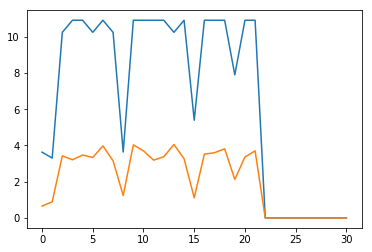

In [241]:
# testw()
q = np.arange(qnum)
print(len(q))
print(len(NDCG_Yq))
print(len(NDCG_Y_hat))
plt.plot(q, NDCG_Yq)
plt.plot(q, NDCG_Y_hat)